# Exploring Linear Regression Through Boston House Dataset

**Advanced Intelligent Systems - Summative Lab Exercise #1**

*Alvarez, Aaron Jetro C.*


# 1) Importing Libraries and data set

*If libraries are already installed, you can change the next cell to  'raw' or 'markdown' to avoid pip install*

In [1]:
!pip install -q statsmodels scipy

In [2]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats import boxcox, yeojohnson, skew, uniform
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
#Importing data set
data = pd.read_csv("boston.csv")

### Some User Defined Functions

*These user defined functions are used to lessen redundancy on the experimenttation part, you can fold this tab for readability of the main code*

*1) Function to print graph of models (accepts list of models)*

In [4]:
def plot_model_performance(models, X_test, y_test, X_train):

    """
    Plot model performance metrics.

    Parameters:
    - models: A list of models.
    - X_train: Features for training.
    - y_train: Target for training.
    - X_test: Features for testing.
    - y_test: Target for testing.
    """
    
    plt.figure(figsize=(9, 5 * len(models)))

    for i, model in enumerate(models, 1):
        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        adj_r2 = adjusted_r2_score(y_test, y_pred, model, X_train)  # Uses X_train for adjusted R²
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Plot actual vs. predicted
        plt.subplot(len(models), 1, i)
        plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line

        # Add title and labels
        plt.title(f'{model.__class__.__name__} - Actual vs. Predicted\nModel score: {r2:.4f}')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')

        # Annotate the plot with metrics
        plt.text(0.05, 0.9, f'MSE: {mse:.6f}\nR²: {r2:.6f}\nAdj R²: {adj_r2:.6f}\nMAPE: {mape:.6f}', transform=plt.gca().transAxes,
                 fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout()

    plt.suptitle('Actual vs. Predicted for All Models', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


*2) Function to print graph of models (accepts dictionaries of models)*

In [5]:
def plot_model_performance_dict(model_dict, X_train, y_train, X_test, y_test):
    """
    Plot model performance metrics.

    Parameters:
    - model_dict: A dictionary with model names as keys and model instances as values.
    - X_train: Features for training.
    - y_train: Target for training.
    - X_test: Features for testing.
    - y_test: Target for testing.
    """
    plt.figure(figsize=(9, 5 * len(model_dict)))
    
    for i, (name, model) in enumerate(model_dict.items(), 1):
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        adj_r2 = adjusted_r2_score(y_test, y_pred, model, X_test)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        # Plot actual vs. predicted
        plt.subplot(len(model_dict), 1, i)
        plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
        
        # Add title and labels
        plt.title(f'{name} - Actual vs. Predicted\nModel score: {r2:.4f}')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        
        # Annotate the plot with metrics
        plt.text(0.05, 0.9, f'MSE: {mse:.4f}\nR²: {r2:.4f}\nAdj R²: {adj_r2:.4f}\nMAPE: {mape:.4f}', 
                 transform=plt.gca().transAxes, fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.suptitle('Actual vs. Predicted for All Models', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


*3) Function to calculate adjusted r2 score(accepts list of models)*

In [6]:
# User defined function to calculate Adjusted R-squared
def adjusted_r2_score(y_true, y_pred, model, X):
    r2 = r2_score(y_true, y_pred)
    n = X.shape[0]  # Number of observations
    p = X.shape[1]  # Number of predictors
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adj_r2

*4) Function to print graph of models (accepts list of models), prints the test and training performance metrics*

In [7]:
def print_model_metrics(models, X_train, y_train, X_test, y_test):
    # Print table headers
    header_test = f"{'Model':<30} {'MSE (Test)':<20} {'R² (Test)':<20} {'Adj R² (Test)':<20} {'MAPE (Test)':<20}"
    header_train = f"{'Model':<30} {'MSE (Train)':<20} {'R² (Train)':<20} {'Adj R² (Train)':<20} {'MAPE (Train)':<20}"
    
    print(header_train)
    print("=" * len(header_train))
    
    # Train each model and print metrics
    for model in models:
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)
        
        # Predict on training and test data
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate metrics for training data
        mse_train = mean_squared_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)
        adj_r2_train = adjusted_r2_score(y_train, y_train_pred, model, X_train)
        mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
        
        # Calculate metrics for test data
        mse_test = mean_squared_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        adj_r2_test = adjusted_r2_score(y_test, y_test_pred, model, X_test)
        mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
        
        # Format metrics
        mse_train_fmt = f"{mse_train:.4f}"
        r2_train_fmt = f"{r2_train:.4f}"
        adj_r2_train_fmt = f"{adj_r2_train:.4f}"
        mape_train_fmt = f"{mape_train:.4f}"
        
        mse_test_fmt = f"{mse_test:.4f}"
        r2_test_fmt = f"{r2_test:.4f}"
        adj_r2_test_fmt = f"{adj_r2_test:.4f}"
        mape_test_fmt = f"{mape_test:.4f}"
        
        # Print metrics for training data
        print(f"{model_name:<30} {mse_train_fmt:<20} {r2_train_fmt:<20} {adj_r2_train_fmt:<20} {mape_train_fmt:<20}")
    
    print("\n" + header_test)
    print("=" * len(header_test))
    
    # Print metrics for test data
    for model in models:
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)
        
        # Predict on test data
        y_test_pred = model.predict(X_test)
        
        # Calculate metrics for test data
        mse_test = mean_squared_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        adj_r2_test = adjusted_r2_score(y_test, y_test_pred, model, X_test)
        mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
        
        # Format metrics
        mse_test_fmt = f"{mse_test:.4f}"
        r2_test_fmt = f"{r2_test:.4f}"
        adj_r2_test_fmt = f"{adj_r2_test:.4f}"
        mape_test_fmt = f"{mape_test:.4f}"
        
        # Print metrics for test data
        print(f"{model_name:<30} {mse_test_fmt:<20} {r2_test_fmt:<20} {adj_r2_test_fmt:<20} {mape_test_fmt:<20}")


*4) Function to print graph of models (accepts dictionary of models), prints the test and training performance metrics*

In [8]:
def print_model_list(best_models, X_train, y_train, X_test, y_test):
    # Print table headers
    header_train = f"{'Model':<30} {'MSE (Train)':<20} {'R² (Train)':<20} {'Adj R² (Train)':<20} {'MAPE (Train)':<20}"
    header_test = f"{'Model':<30} {'MSE (Test)':<20} {'R² (Test)':<20} {'Adj R² (Test)':<20} {'MAPE (Test)':<20}"
    
    print(header_train)
    print("=" * len(header_train))
    
    # Print each model's training metrics
    for name, model in best_models.items():
        # Predict on training and test data
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate metrics for training data
        mse_train = mean_squared_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)
        adj_r2_train = adjusted_r2_score(y_train, y_train_pred, model, X_train)
        mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
        
        # Calculate metrics for test data
        mse_test = mean_squared_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        adj_r2_test = adjusted_r2_score(y_test, y_test_pred, model, X_test)
        mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
        
        # Print training metrics
        print(f"{name:<30} {mse_train:<20.4f} {r2_train:<20.4f} {adj_r2_train:<20.4f} {mape_train:<20.4f}")
    
    print("\n" + header_test)
    print("=" * len(header_test))
    
    # Print each model's test metrics
    for name, model in best_models.items():
        y_test_pred = model.predict(X_test)
        
        # Calculate metrics for test data
        mse_test = mean_squared_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        adj_r2_test = adjusted_r2_score(y_test, y_test_pred, model, X_test)
        mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
        
        # Print test metrics
        print(f"{name:<30} {mse_test:<20.4f} {r2_test:<20.4f} {adj_r2_test:<20.4f} {mape_test:<20.4f}")


# 2) Exploratory Data Analysis

#### Exploring the data set through inspection

In [9]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [10]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695   

In [11]:
#First attempt: Checking all the variables pf the dataset
df = data.copy()

In [12]:
#Identifiying possible abnormalities / values with null or empty data set

print(df.isnull().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


#### Exploring dataset through various plots.

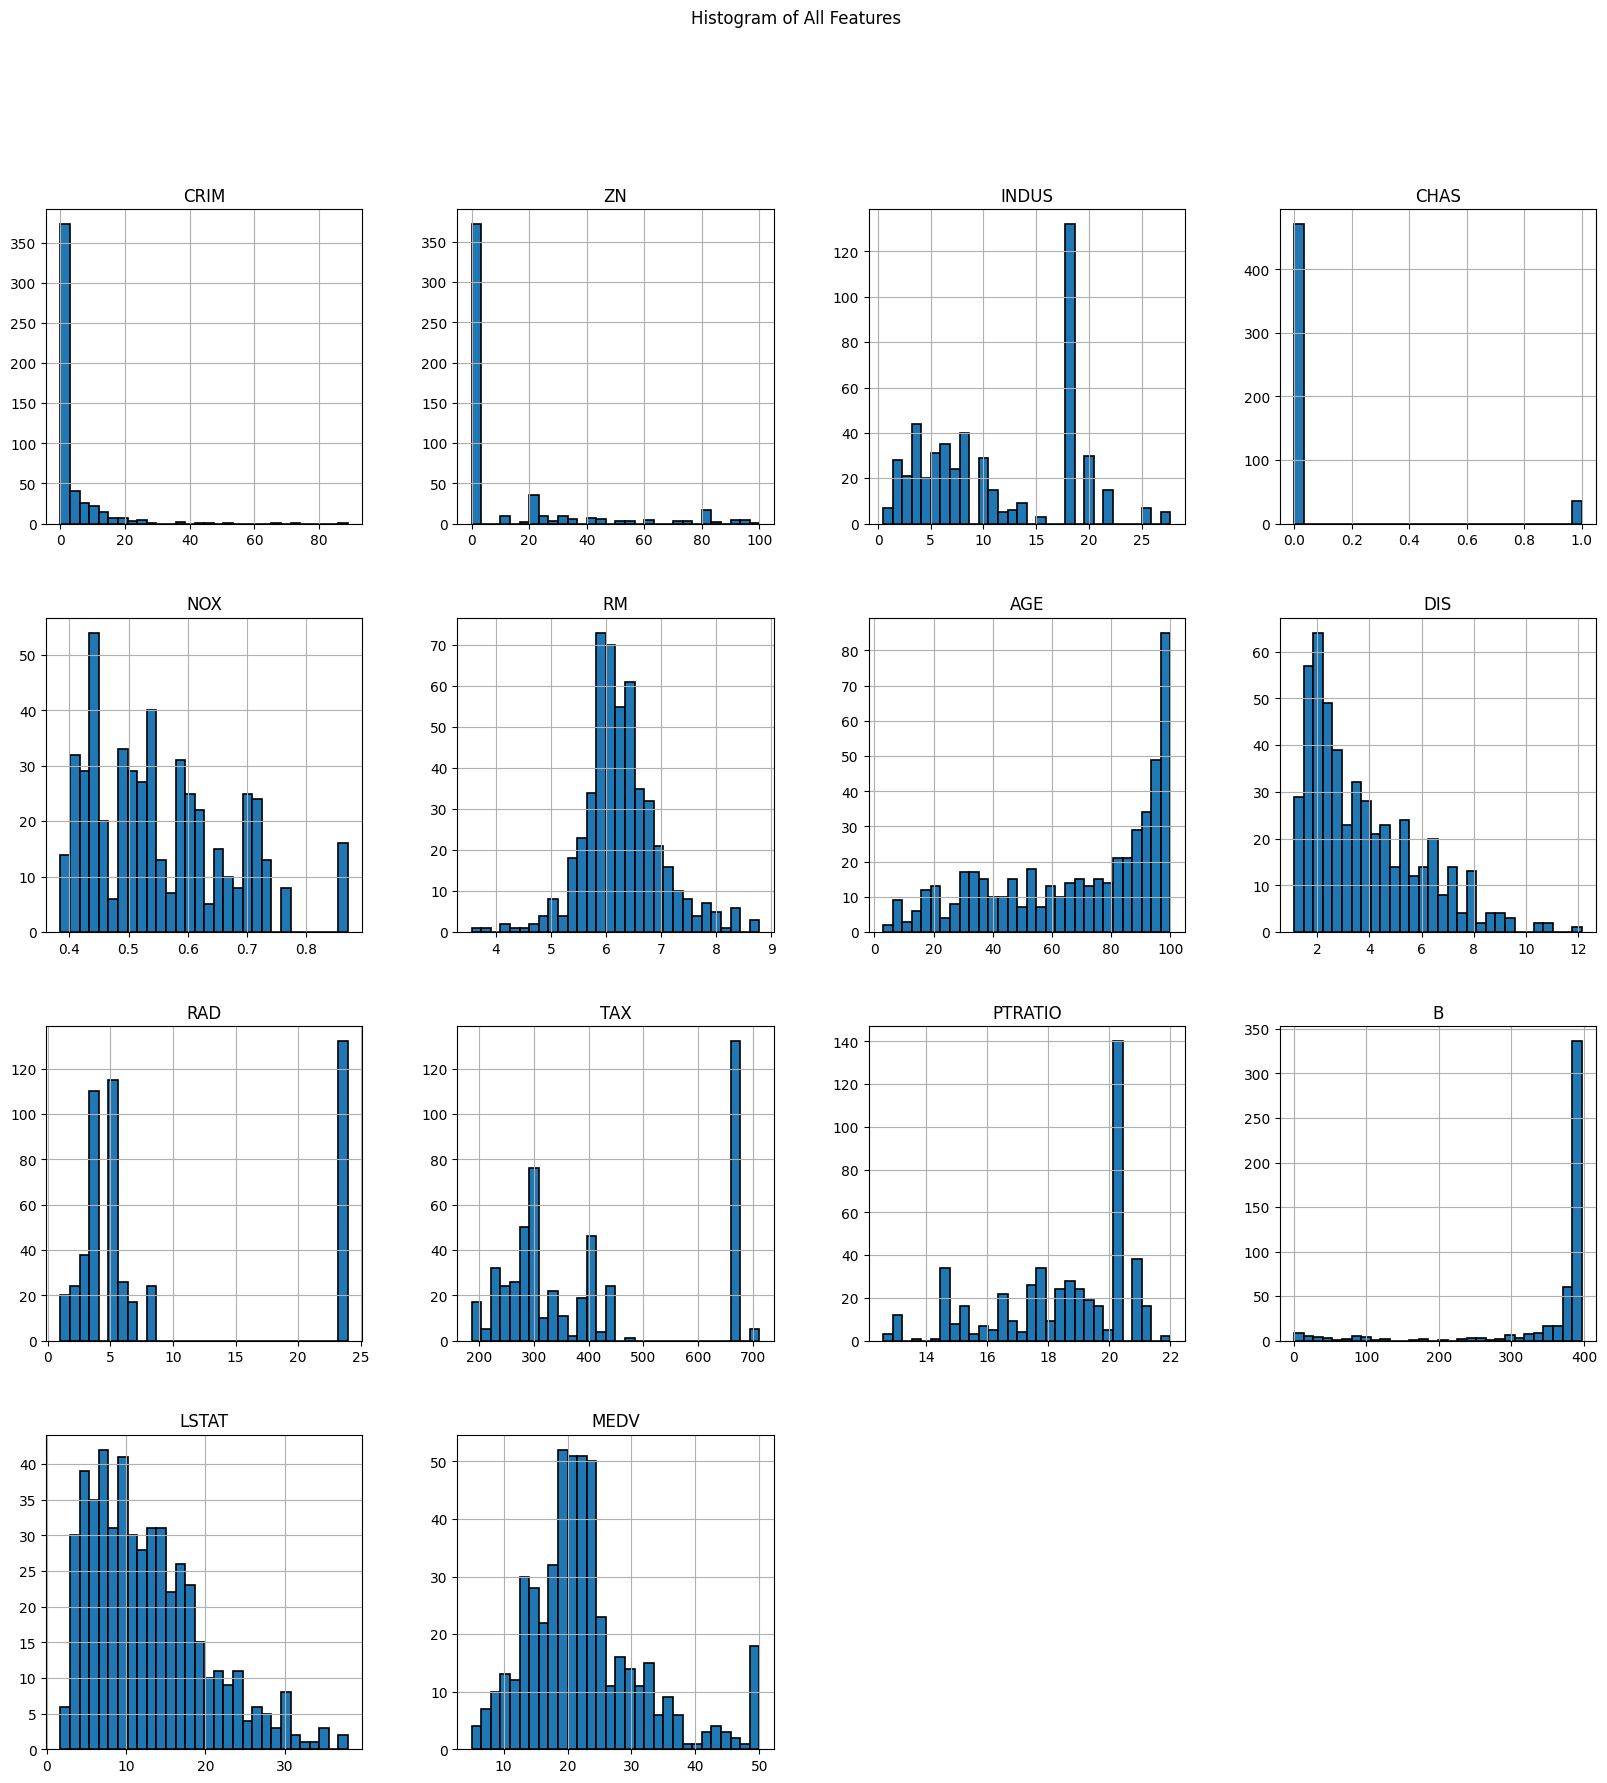

In [13]:
#Checking the distribution of data and potential outliers using histogram.
data.hist(bins=30, edgecolor='black', linewidth=1.2, figsize=(20, 20))
plt.suptitle('Histogram of All Features')
plt.show()

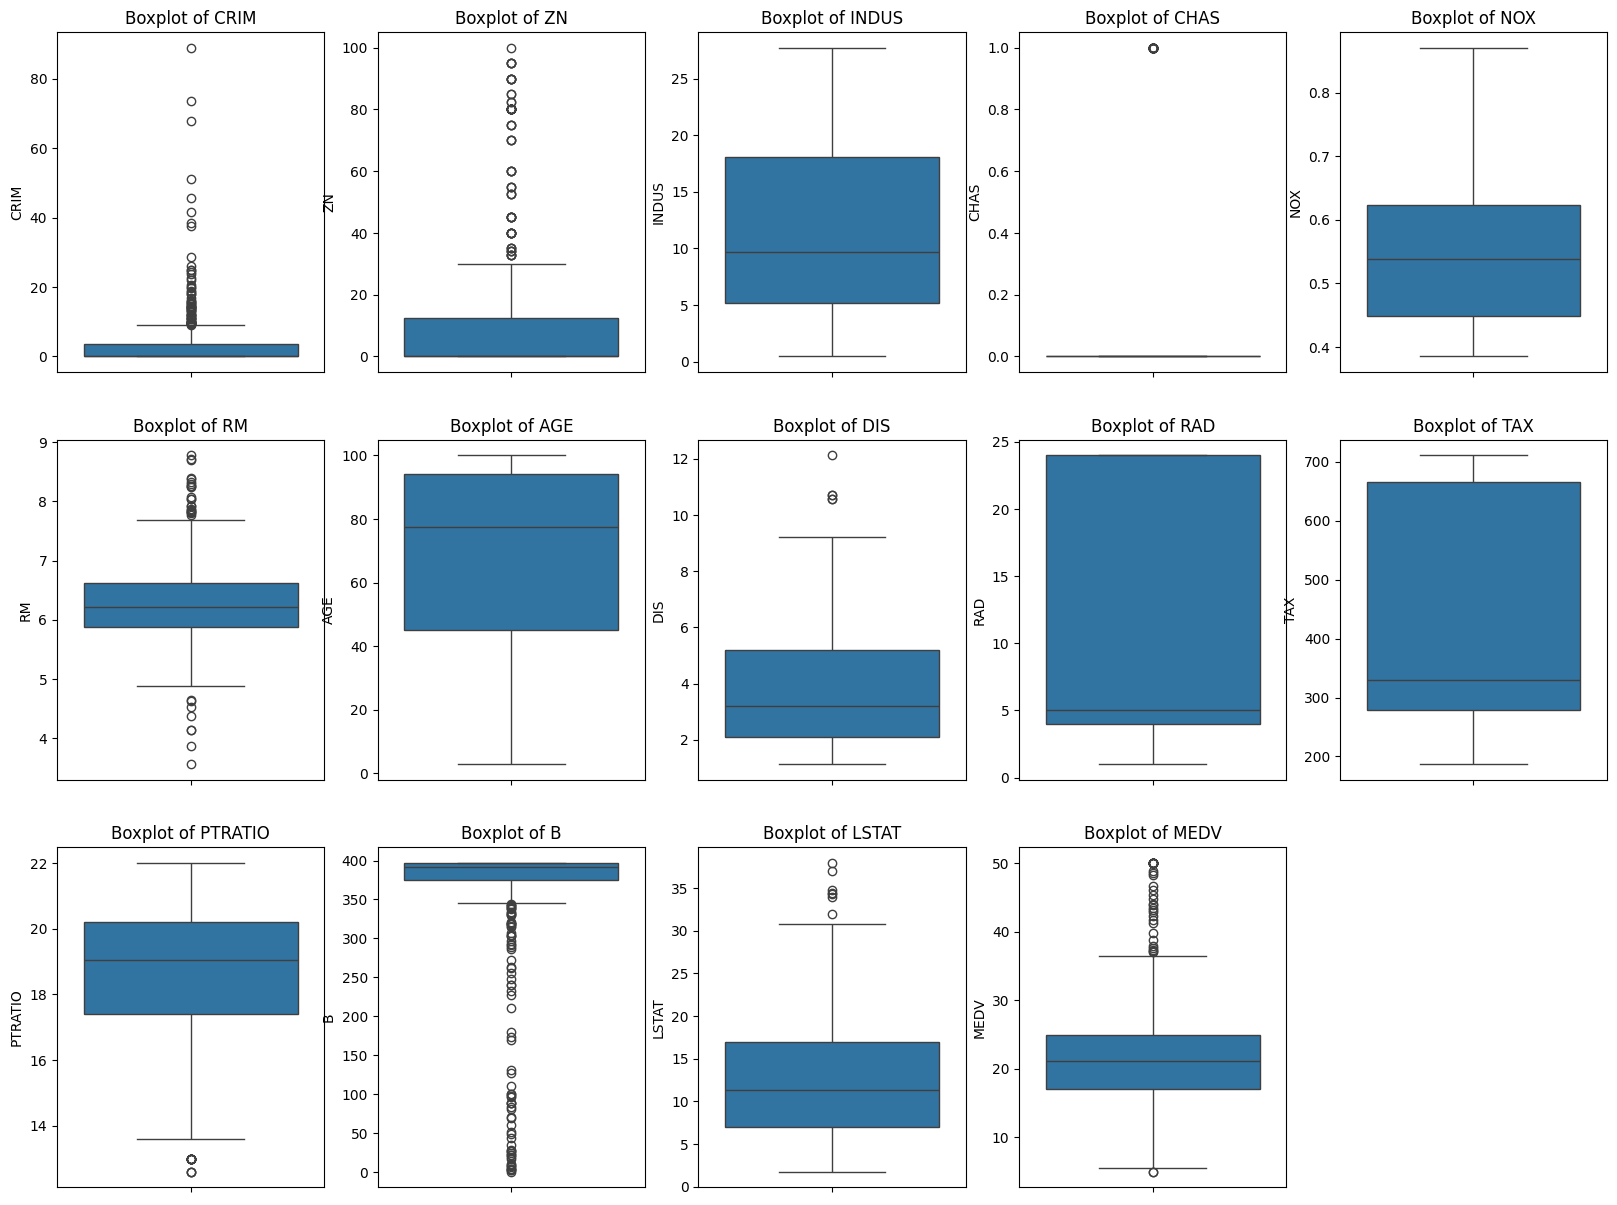

In [14]:
#Checking for outliers using boxplot

plt.figure(figsize = (20,15))

for i, column in enumerate(data.columns,1):
    plt.subplot(3,5,i)
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')

plt.show()

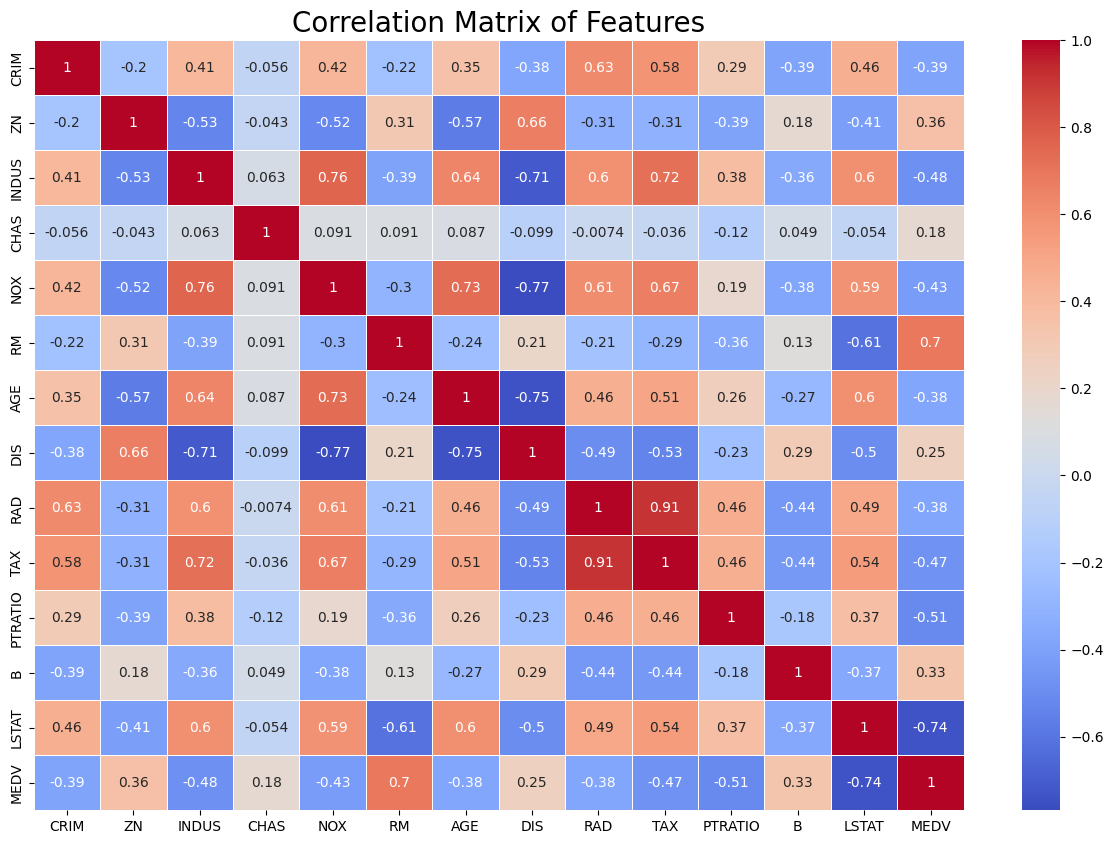

In [15]:
# Creating a heatmap of correlation matrix

corr_matrix = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features', fontsize=20)
plt.show()

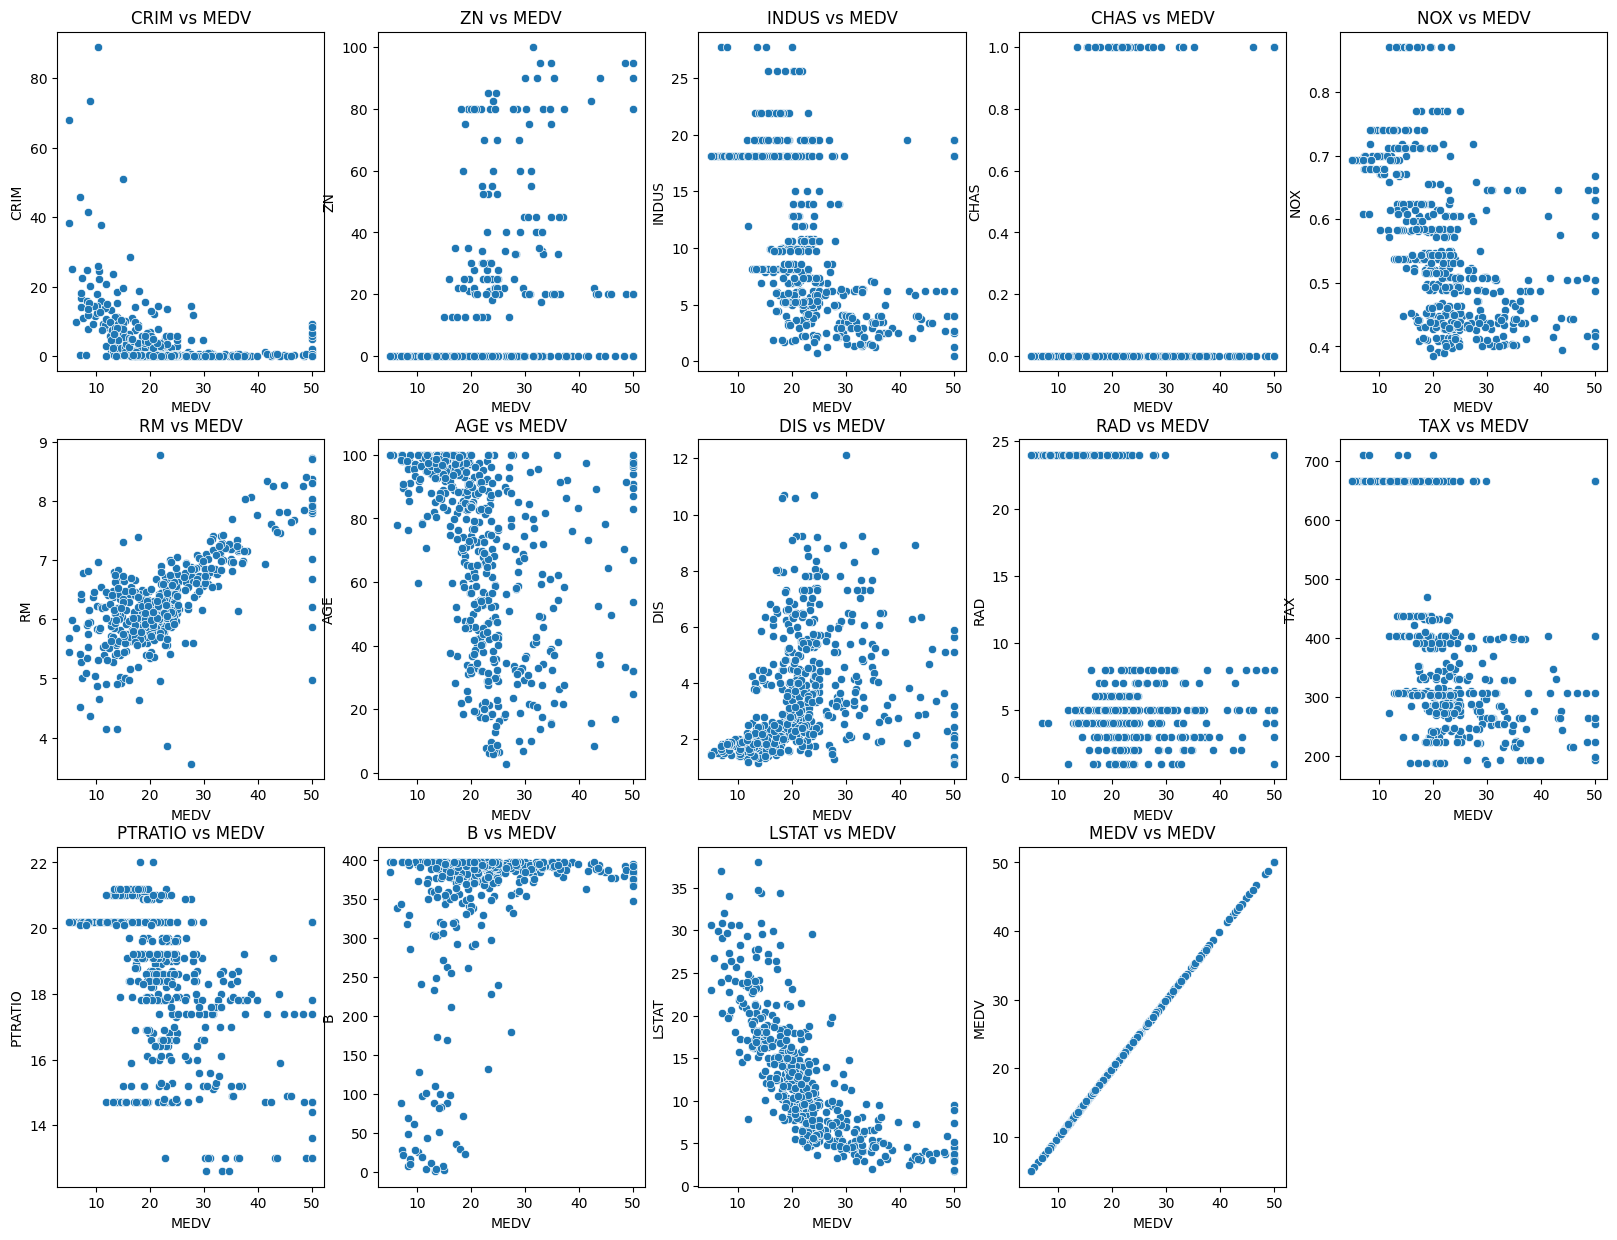

In [16]:
#creating scatterplots for each feature vs. MEDV using a loop

plt.figure(figsize=(20,15))
for i, feature in enumerate(data.columns,1):
    plt.subplot(3,5,i)
    sns.scatterplot(x='MEDV', y=feature, data=data)
    plt.title(f'{feature} vs MEDV')

plt.show()

# 3) Data Preprocessing

#### Feature Selection

In [17]:
#feature selection:
corr_target = corr_matrix['MEDV'].sort_values(ascending=False)

# Get top 5 most positively and negatively correlated features
pos = corr_target.head(6)  # Includes MEDV itself since medv is 1
neg = corr_target.tail(5)

# Drop 'MEDV' itself from the positive correlations
pos = pos.drop('MEDV')

# Create a DataFrame for the results
correlation_df = pd.DataFrame({
    'Feature': np.concatenate([pos.index, neg.index]),
    'Correlation with MEDV': np.concatenate([pos.values, neg.values])
})

# Display the DataFrame
correlation_df.reset_index(drop=True, inplace=True)
print(correlation_df)


   Feature  Correlation with MEDV
0       RM               0.695360
1       ZN               0.360445
2        B               0.333461
3      DIS               0.249929
4     CHAS               0.175260
5      NOX              -0.427321
6      TAX              -0.468536
7    INDUS              -0.483725
8  PTRATIO              -0.507787
9    LSTAT              -0.737663


#### Data Splitting

In [18]:
# Splitting the data into training and testing sets 

used_features = ['RM','LSTAT','PTRATIO']
X = df[used_features].copy()
y = df['MEDV'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
# maintaining old copies of data split so it can be used for the experiment
XOld_train = X_train.copy()
XOld_test = X_test.copy()
yOld_train = y_train.copy()
yOld_test = y_test.copy()

#### Removing Outliers and Treating Skewness of Selected Features

In [20]:
# A user made function to transform multiple features simultaneously.

def Transform(dataset, column, i):
    if i == 'pos':
        for cols in column:
            dataset[cols] = np.log(dataset[cols]+1)
        return dataset
    else:
        for cols in column:
            dataset[cols],_ = yeojohnson(dataset[cols])
        return dataset

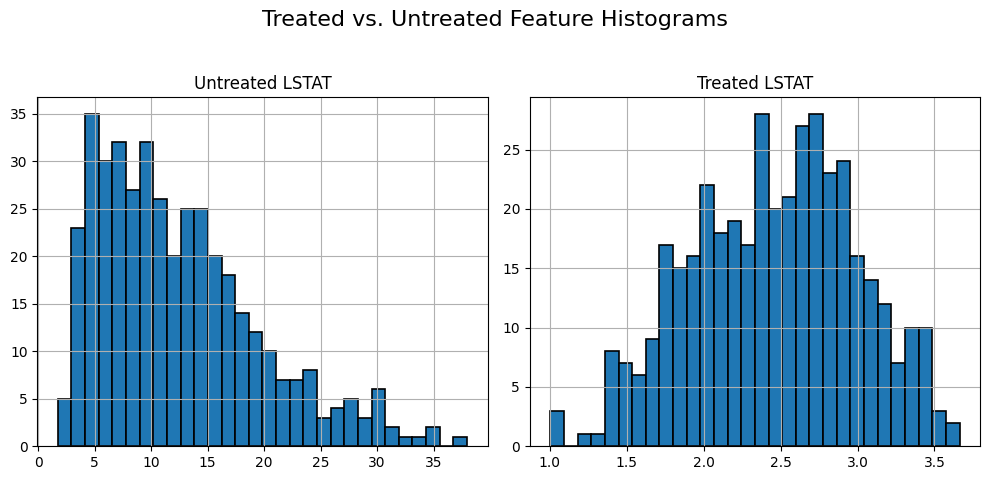

Skewness of untreated LSTAT: 0.9302494684182955
Skewness of treated LSTAT: -0.15118233318832475


In [21]:
# Specifying the columns to be transformed.
skewed_column = ['LSTAT']

transformed = skewed_column

# Using log transformation for positive skewed variables
X_train = Transform(X_train,skewed_column,'pos')
X_test = Transform(X_test,skewed_column,'pos')

# Plotting treated vs untreated features side by side
plt.figure(figsize=(10, 5 * len(transformed)))

# Stores the skewed value for the transformed features (useful when there are multiple features to be transformed)
untreated_skews = []
treated_skews = []

# Printing the histogram of the skewed vs unskewed features
for i, feature in enumerate(transformed, 1):
    # Treated feature histogram (should be on the right)
    plt.subplot(len(transformed), 2, 2 * i)
    X_train[feature].hist(bins=30, edgecolor='black', linewidth=1.2)
    plt.title(f'Treated {feature}')
    treated_skews.append(skew( X_train[feature]))

    # Untreated feature histogram (should be on the left)
    plt.subplot(len(transformed), 2, 2 * i - 1)
    XOld_train[feature].hist(bins=30, edgecolor='black', linewidth=1.2)
    plt.title(f'Untreated {feature}')
    untreated_skews.append(skew(XOld_train[feature]))

plt.suptitle('Treated vs. Untreated Feature Histograms', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print the skewness values for untreated and treated features
for i, feature in enumerate(transformed):
    print(f"Skewness of untreated {feature}: {untreated_skews[i]}")
    print(f"Skewness of treated {feature}: {treated_skews[i]}")



Original data shape: (404, 3)
Cleaned data shape: (398, 3)


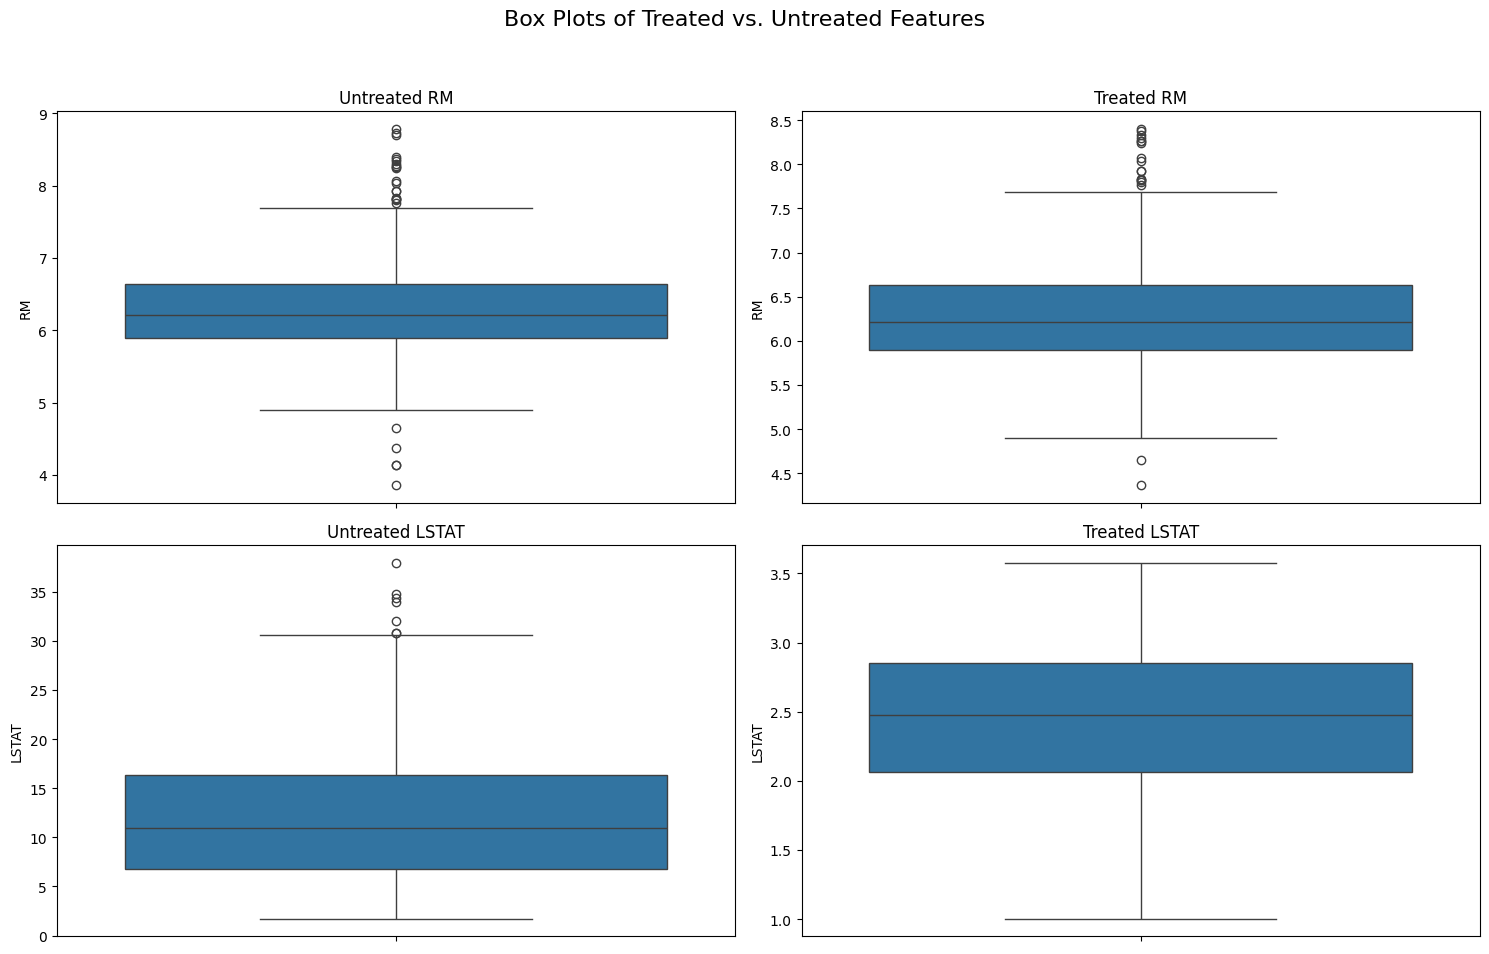

In [22]:
# Removing outliers from the data sets:

# User defined function to help remove outliers using zscore
def remove_outliers_zscore(df, columns, threshold=3):
    zs = np.abs((df[columns] - df[columns].mean()) / df[columns].std())
    return df[(zs < threshold).all(axis=1)]

features_to_clean =['RM','LSTAT']

# Remove outliers for specified features
X_train = remove_outliers_zscore(X_train, features_to_clean)
X_test = remove_outliers_zscore(X_test, features_to_clean)
y_train= y_train[X_train.index]
y_test= y_test[X_test.index]


# Check the result
print(f"Original data shape: {XOld_train.shape}")
print(f"Cleaned data shape: {X_train.shape}")

# Plotting treated vs untreated box plots side by side
plt.figure(figsize=(15, 5 * len(features_to_clean)))

for i, feature in enumerate(features_to_clean, 1):
    # Untreated feature box plot
    plt.subplot(len(features_to_clean), 2, 2 * i - 1)
    sns.boxplot(y=XOld_train[feature])
    plt.title(f'Untreated {feature}')
    
    # Treated feature box plot
    plt.subplot(len(features_to_clean), 2, 2 * i)
    sns.boxplot(y=X_train[feature])
    plt.title(f'Treated {feature}')

plt.suptitle('Box Plots of Treated vs. Untreated Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### 

#### Normalizing/ Scaling the datasets

In [23]:
# Feature scaling User defined function

def scale_features(X_train, X_test, used_features):
    """
    Scale the specified features in training and testing datasets.

    Parameters:
    - X_train: Training features DataFrame.
    - X_test: Testing features DataFrame.
    - used_features: List of feature names to be scaled.

    Returns:
    - X_train: Training features DataFrame with scaled features.
    - X_test: Testing features DataFrame with scaled features.
    """
    # Create a StandardScaler instance
    scaler = StandardScaler()
    
    # Fit scaler on training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train[used_features])
    X_test_scaled = scaler.transform(X_test[used_features])
    
    # Replace original columns with scaled columns in X_train and X_test
    X_train[used_features] = X_train_scaled
    X_test[used_features] = X_test_scaled
    
    return X_train, X_test

In [24]:
# Feature scaling using user defined method
X_train_scaled, X_test_scaled = scale_features(X_train, X_test, used_features)

# Combine scaled features and target variable
train_with_target = pd.DataFrame(X_train, columns=used_features)
train_with_target['MEDV'] = y_train.values


In [25]:
# Calculate the correlation matrix
corr_matrix = train_with_target.corr()
# Display the correlation matrix
print(corr_matrix)

               RM     LSTAT   PTRATIO      MEDV
RM       1.000000 -0.671087 -0.338622  0.724416
LSTAT   -0.671087  1.000000  0.392015 -0.813358
PTRATIO -0.338622  0.392015  1.000000 -0.483242
MEDV     0.724416 -0.813358 -0.483242  1.000000


In [26]:
# Printing out the VIF of used features.

vif_data = pd.DataFrame()
vif_data["Feature"] = used_features
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]
vif_data["VIF"] = vif_data["VIF"].round(2)

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
   Feature   VIF
0       RM  1.84
1    LSTAT  1.93
2  PTRATIO  1.20


In [27]:
XOld_train #unscaled

,RM,LSTAT,PTRATIO
477,5.304,24.91,20.2
15,5.834,8.47,21.0
332,6.031,7.83,16.9
423,6.103,23.29,20.2
19,5.727,11.28,21.0
...,...,...,...
106,5.836,18.66,20.9
270,5.856,13.00,18.6
348,6.635,5.99,17.0
435,6.629,23.27,20.2


In [28]:
X_train #scaled

,RM,LSTAT,PTRATIO
477,-1.547654,1.484774,0.849727
15,-0.736124,-0.394984,1.210368
332,-0.434480,-0.525669,-0.637918
423,-0.324235,1.364193,0.849727
19,-0.899961,0.090304,1.210368
...,...,...,...
106,-0.733062,0.969231,1.165288
270,-0.702438,0.335121,0.128444
348,0.490357,-0.962083,-0.592838
435,0.481170,1.362654,0.849727


# 4) Model Implementation and Evaluation

I will be using a user defined function that trains all the regression models

In [29]:
def train_models(alpha=0.5, alpha_ridge=None, alpha_lasso=None, alpha_elastic_net=None, l1_ratio=0.5):
    # Use the default alpha if specific alpha values are not provided
    alpha_ridge = alpha if alpha_ridge is None else alpha_ridge
    alpha_lasso = alpha if alpha_lasso is None else alpha_lasso
    alpha_elastic_net = alpha if alpha_elastic_net is None else alpha_elastic_net

    # Regression Models with specified alpha values
    linear_reg = LinearRegression()
    ridge_reg = Ridge(alpha=alpha_ridge)
    lasso_reg = Lasso(alpha=alpha_lasso)
    elastic_net_reg = ElasticNet(alpha=alpha_elastic_net, l1_ratio=l1_ratio)
   
    # List of models for easy iteration
    models = [linear_reg, ridge_reg, lasso_reg, elastic_net_reg]

    # Train each model
    for model in models:
        model.fit(X_train, y_train)
    
    return models

#### Base Model

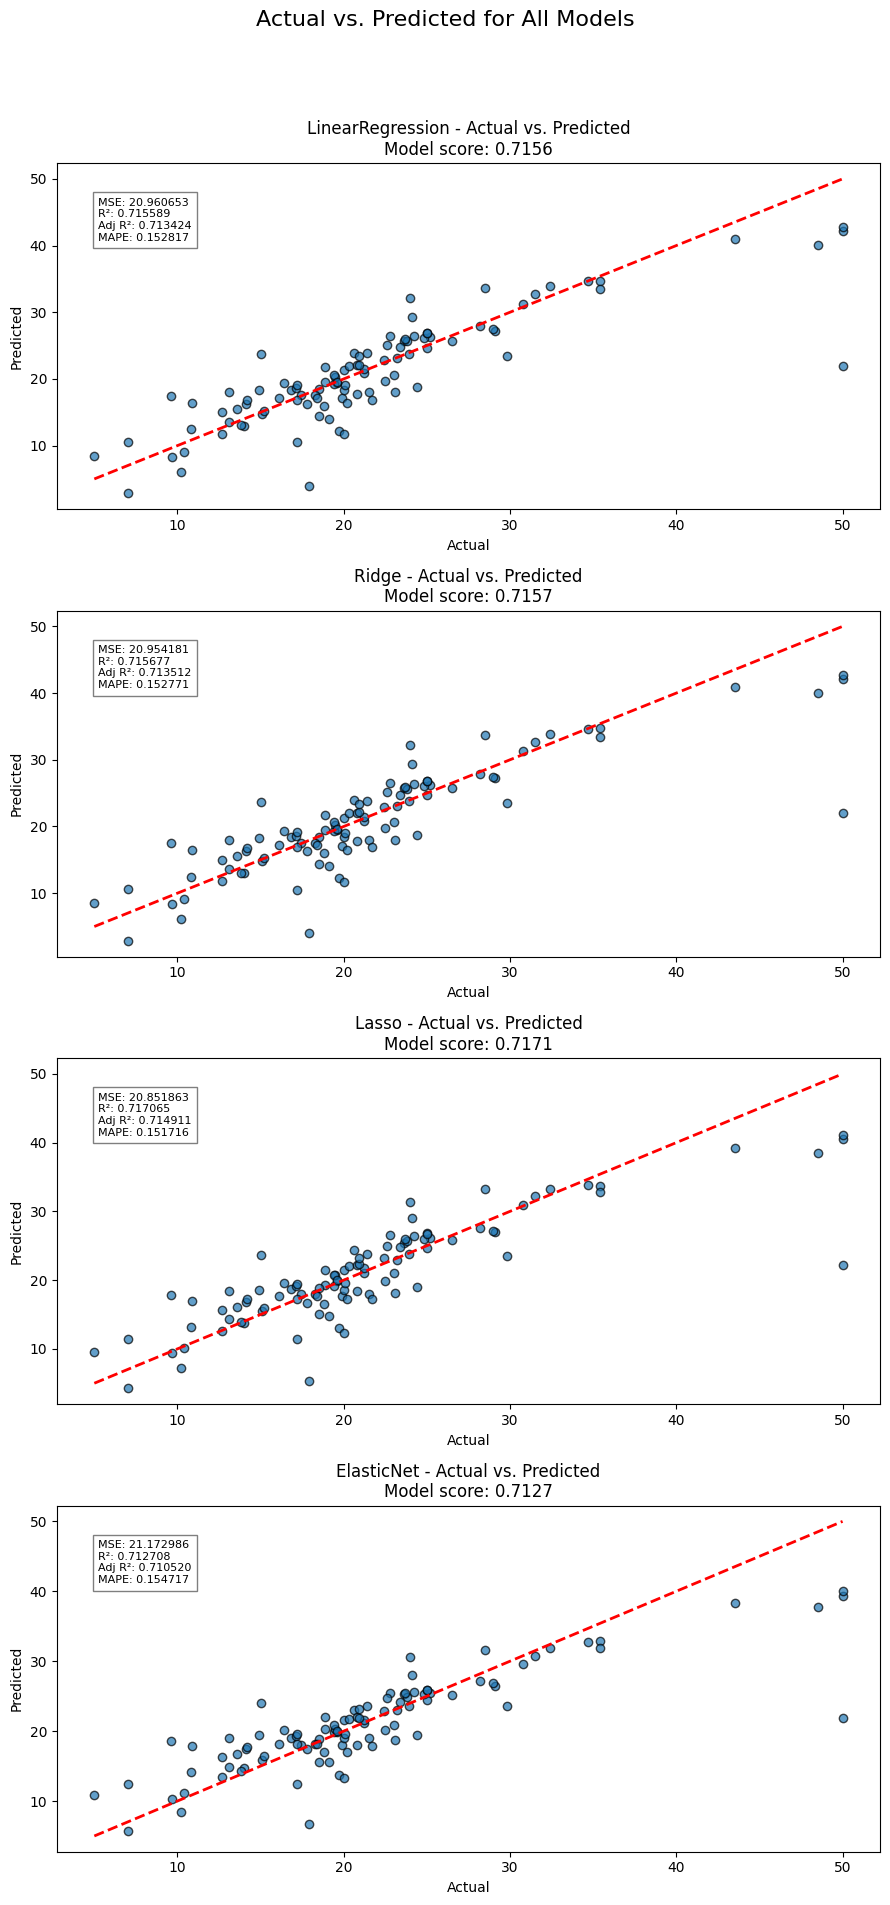

In [30]:
# Uses 0.5 as the default alpha value for all the models
models = train_models(alpha=0.5, l1_ratio=0.5)
    
# Userdefined Function to print models  
plot_model_performance(models, X_test, y_test, X_train)

In [31]:
# User defined method to print metrics
print_model_metrics(models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               21.5785              0.7430               0.7410               0.1730              
Ridge                          21.5786              0.7430               0.7410               0.1730              
Lasso                          21.9724              0.7383               0.7363               0.1732              
ElasticNet                     23.1117              0.7247               0.7226               0.1770              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               20.9607              0.7156               0.7068               0.1528              
Ridge                          20.9542              0.7157               0.7069               0.1528              
Lasso                          20.8519              0.7171               0.7083

### Hyperparameter Tuning

#### Manual Tuning

In [32]:
# Feature scaling using user defined method
X_train_scaled, X_test_scaled = scale_features(X_train, X_test, used_features)

In [33]:
# High value alpha = 50
models = train_models(alpha=50)

# Print model metrics
print_model_metrics(models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               21.5785              0.7430               0.7410               0.1730              
Ridge                          21.8866              0.7393               0.7373               0.1732              
Lasso                          83.9531              0.0000               -0.0076              0.3646              
ElasticNet                     83.9531              0.0000               -0.0076              0.3646              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               20.9607              0.7156               0.7068               0.1528              
Ridge                          20.6614              0.7196               0.7110               0.1498              
Lasso                          75.3435              -0.0223              -0.053

In [34]:
# Mid value alpha = 5
models = train_models(alpha=5)

# Print model metrics
print_model_metrics(models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               21.5785              0.7430               0.7410               0.1730              
Ridge                          21.5825              0.7429               0.7410               0.1729              
Lasso                          53.4139              0.3638               0.3589               0.2790              
ElasticNet                     55.3221              0.3410               0.3360               0.2891              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               20.9607              0.7156               0.7068               0.1528              
Ridge                          20.8998              0.7164               0.7076               0.1524              
Lasso                          46.4475              0.3698               0.3503

In [35]:
# Low value alpha = 0.01
models = train_models(alpha=0.01)

# Print model metrics
print_model_metrics(models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               21.5785              0.7430               0.7410               0.1730              
Ridge                          21.5785              0.7430               0.7410               0.1730              
Lasso                          21.5787              0.7430               0.7410               0.1730              
ElasticNet                     21.5794              0.7430               0.7410               0.1729              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               20.9607              0.7156               0.7068               0.1528              
Ridge                          20.9605              0.7156               0.7068               0.1528              
Lasso                          20.9513              0.7157               0.7069

#### GridSearchCV Tuning

In [36]:
# Feature scaling using user defined method
X_train_scaled, X_test_scaled = scale_features(X_train, X_test, used_features)

In [37]:
#Trying out GridSearchCV to find the best values for each model:

# Define models and their parameter grids
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.1, 0.5, 1.0, 10.0, 50.0]},
    'Lasso': {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]},
    'ElasticNet': {'alpha': [0.01, 0.1, 0.5, 1.0], 
                   'l1_ratio': [0.1, 0.5, 0.7, 1.0]}
}


In [38]:
best_models = {}
for name, model in models.items():
    print(f'Performing GridSearchCV for {name}:')
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    print(f'Best parameters for {name}: {grid_search.best_params_}')
    print(f'Best score for {name}: {-grid_search.best_score_}')
    print("=" * 50)

# Maintaining an copy of the tuned models using gridsearch, for later comparison and evaluation.
gridmodels, gridX_train,gridX_test, gridy_test, gridy_train = best_models.copy(),X_train.copy(),X_test.copy(),y_train.copy(),y_test.copy()

Performing GridSearchCV for LinearRegression:
Best parameters for LinearRegression: {}
Best score for LinearRegression: 22.72441781653532
Performing GridSearchCV for Ridge:
Best parameters for Ridge: {'alpha': 10.0}
Best score for Ridge: 22.683202316603357
Performing GridSearchCV for Lasso:
Best parameters for Lasso: {'alpha': 0.01}
Best score for Lasso: 22.724557929301987
Performing GridSearchCV for ElasticNet:
Best parameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.1}
Best score for ElasticNet: 22.706732767097563


In [39]:
# Prints a table of the values of the models
print_model_list(best_models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               21.5785              0.7430               0.7410               0.1730              
Ridge                          21.5937              0.7428               0.7408               0.1729              
Lasso                          21.5787              0.7430               0.7410               0.1730              
ElasticNet                     21.5807              0.7429               0.7410               0.1729              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               20.9607              0.7156               0.7068               0.1528              
Ridge                          20.8471              0.7171               0.7084               0.1519              
Lasso                          20.9513              0.7157               0.7069

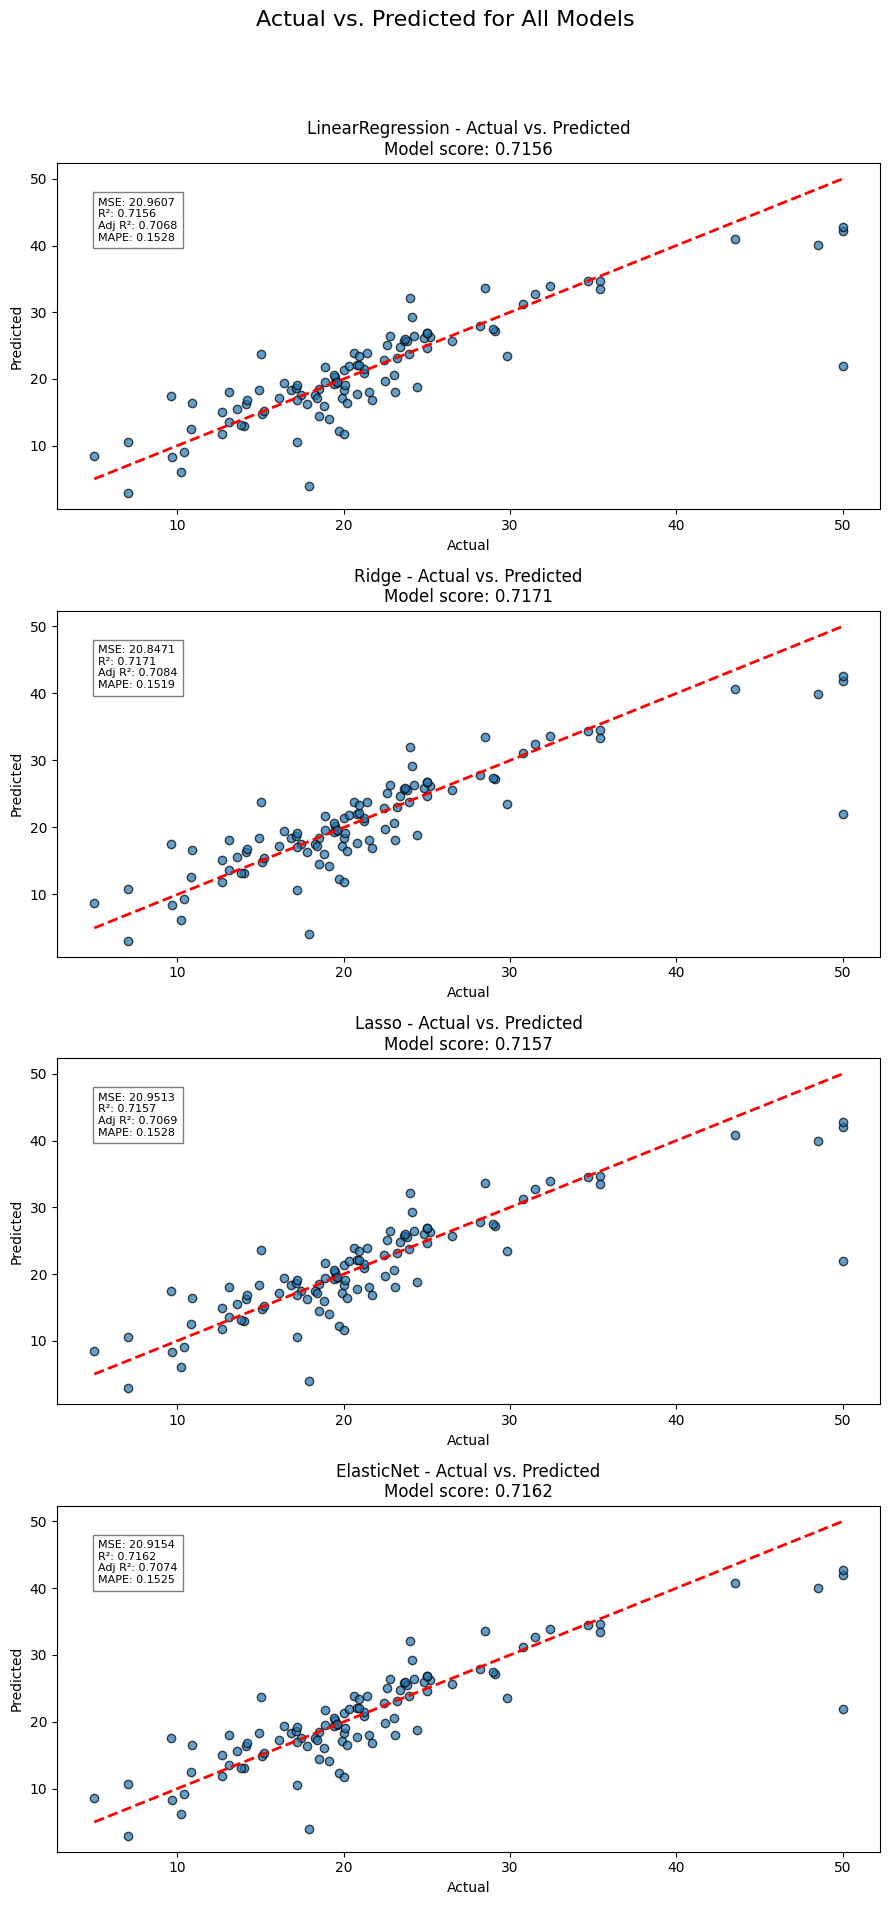

In [40]:
plot_model_performance_dict(best_models, X_train, y_train, X_test, y_test)

#### RandomizedSearch CV Tuning

In [41]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Define models and their parameter distributions
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}

param_distributions = {
'LinearRegression': {},
    'Ridge': {'alpha': uniform(0.1, 50)},  
    'Lasso': {'alpha': uniform(0.01, 10)},  
    'ElasticNet': {'alpha': uniform(0.01, 10), 
                   'l1_ratio': uniform(0.1, 0.9)} 
}

best_models = {}
for name, model in models.items():
    print(f'Performing RandomizedSearchCV for {name}:')
    random_search = RandomizedSearchCV(model, param_distributions[name],n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,random_state=42)
    random_search.fit(X_train, y_train)
    best_models[name] = random_search.best_estimator_

    print(f'Best parameters for {name}: {random_search.best_params_}')
    print(f'Best score for {name}: {-random_search.best_score_}')
    print("=" * 50)

# Maintaining an copy of the tuned models using gridsearch, for later comparison and evaluation.
rsmodels, rsX_train,rsX_test, rsy_test, rsy_train = best_models.copy(),X_train.copy(),X_test.copy(),y_train.copy(),y_test.copy()

Performing RandomizedSearchCV for LinearRegression:
Best parameters for LinearRegression: {}
Best score for LinearRegression: 22.72441781653532
Performing RandomizedSearchCV for Ridge:
Best parameters for Ridge: {'alpha': np.float64(7.900932022121825)}
Best score for Ridge: 22.687195313708063
Performing RandomizedSearchCV for Lasso:
Best parameters for Lasso: {'alpha': np.float64(0.5908361216819946)}
Best score for Lasso: 23.284025661974134
Performing RandomizedSearchCV for ElasticNet:
Best parameters for ElasticNet: {'alpha': np.float64(0.21584494295802448), 'l1_ratio': np.float64(0.9729188669457949)}
Best score for ElasticNet: 22.792980663977822


In [42]:
# Prints a table of the values of the models
print_model_list(best_models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               21.5785              0.7430               0.7410               0.1730              
Ridge                          21.5882              0.7429               0.7409               0.1729              
Lasso                          22.1285              0.7364               0.7344               0.1736              
ElasticNet                     21.6592              0.7420               0.7400               0.1727              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               20.9607              0.7156               0.7068               0.1528              
Ridge                          20.8683              0.7168               0.7081               0.1521              
Lasso                          20.9124              0.7162               0.7075

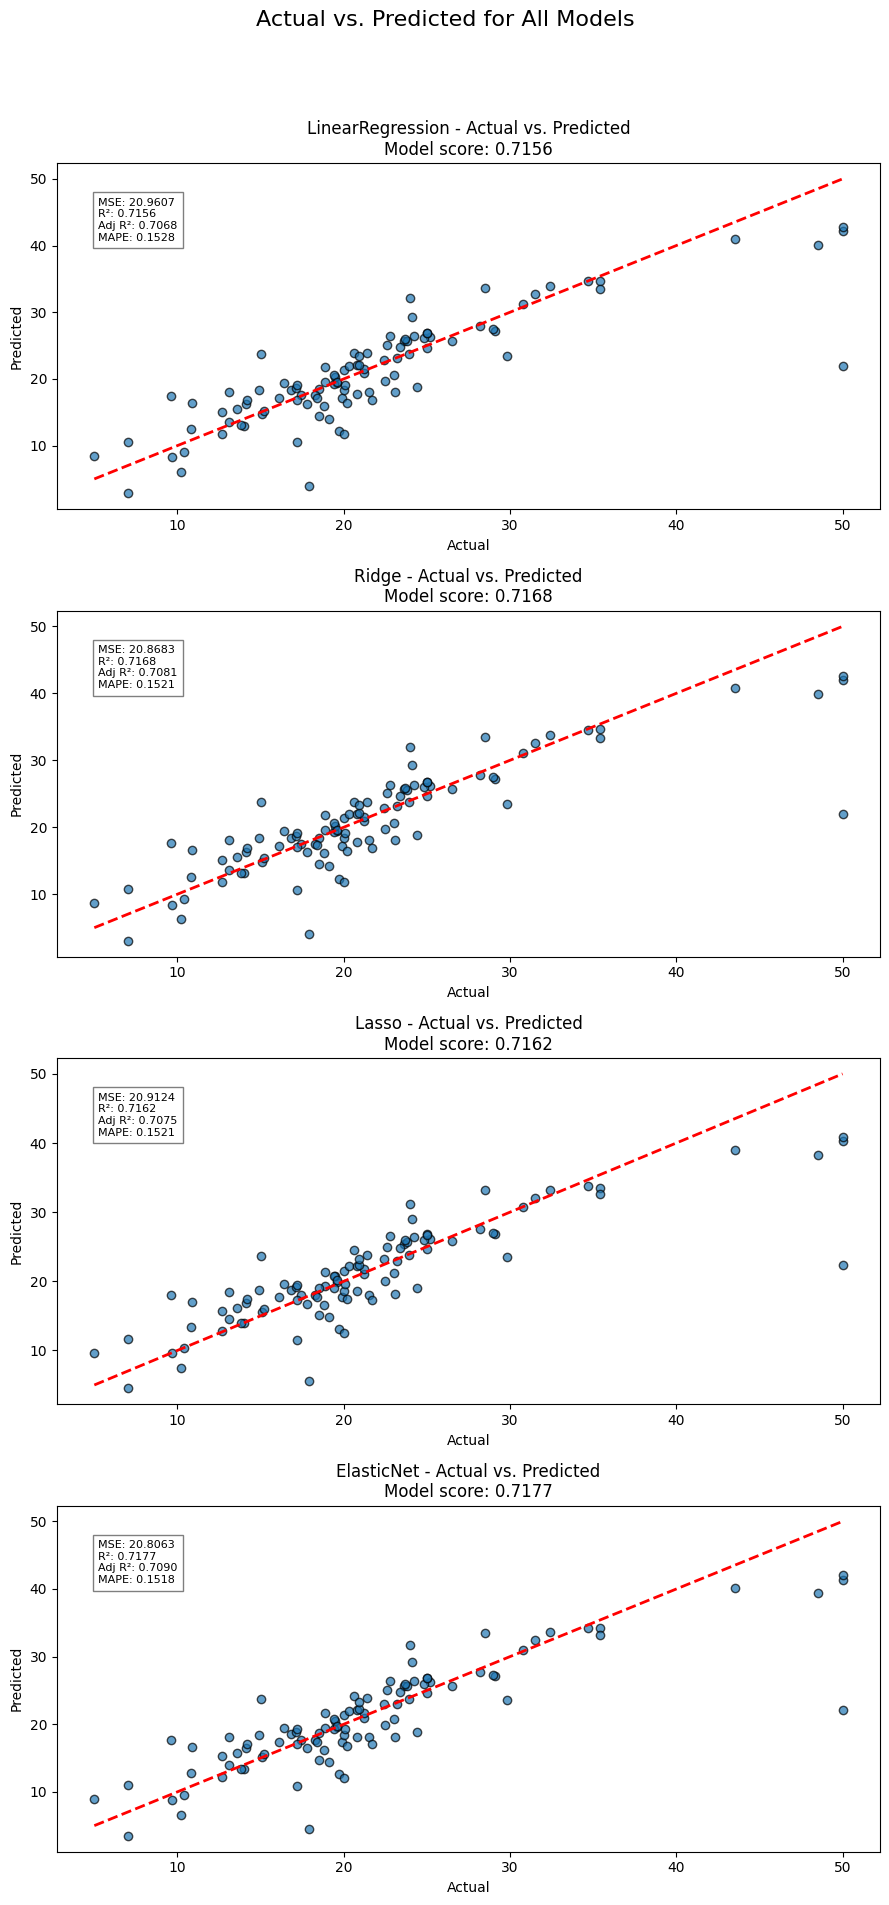

In [43]:
plot_model_performance_dict(best_models, X_train, y_train, X_test, y_test)

# Experiments Done In Preprocessing

### Removing Outliers: Necessary or Unnecessary

In [44]:
# Retrieving copies of split to ensure unmodified values
X_train = XOld_train.copy()
X_test = XOld_test.copy()
y_train = yOld_train.copy()
y_test = yOld_test.copy()

# Treating skewness of graph
X_train = Transform(X_train,skewed_column,'pos')
X_test = Transform(X_test,skewed_column,'pos')

In [45]:
# Feature scaling
X_train_scaled, X_test_scaled = scale_features(X_train, X_test, used_features)

In [46]:
# Uses 0.5 as the default alpha value for all the models
models = train_models(alpha=0.5, l1_ratio=0.5)
    
# Userdefined Function to print models  
print_model_metrics(models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               23.1412              0.7336               0.7316               0.1772              
Ridge                          23.1412              0.7336               0.7316               0.1772              
Lasso                          23.5341              0.7291               0.7271               0.1777              
ElasticNet                     24.7260              0.7154               0.7132               0.1823              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               22.0016              0.7000               0.6908               0.1541              
Ridge                          21.9992              0.7000               0.6908               0.1540              
Lasso                          21.7773              0.7030               0.6939

In [47]:
# Retrieving copies of split to ensure unmodified values
X_train = XOld_train.copy()
X_test = XOld_test.copy()
y_train = yOld_train.copy()
y_test = yOld_test.copy()

X_train = Transform(X_train,skewed_column,'pos')
X_test = Transform(X_test,skewed_column,'pos')

In [48]:
features_to_clean =['RM','LSTAT']

# Remove outliers for specified features
X_train = remove_outliers_zscore(X_train, features_to_clean)
X_test = remove_outliers_zscore(X_test, features_to_clean)
y_train= y_train[X_train.index]
y_test= y_test[X_test.index]

In [49]:
# Feature scaling
X_train_scaled, X_test_scaled = scale_features(X_train, X_test, used_features)

In [50]:
# Uses 0.5 as the default alpha value for all the models
models = train_models(alpha=0.5, l1_ratio=0.5)
    
# Userdefined Function to print models  
print_model_metrics(models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               21.5785              0.7430               0.7410               0.1730              
Ridge                          21.5786              0.7430               0.7410               0.1730              
Lasso                          21.9724              0.7383               0.7363               0.1732              
ElasticNet                     23.1117              0.7247               0.7226               0.1770              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               20.9607              0.7156               0.7068               0.1528              
Ridge                          20.9542              0.7157               0.7069               0.1528              
Lasso                          20.8519              0.7171               0.7083

### Removing Outliers: Before or After Data Split

#### A demonstration of treating data before split

In [51]:
df= data.copy()

transform = ['LSTAT']

#Treating skewness using user defined function

df = Transform(df, transform,'pos')
print(f"Untreated: {skew(data[transform])}")
print(f"Treated: {skew(df[transform])}")

Untreated: [0.90377074]
Treated: [-0.18663965]


In [52]:
df = remove_outliers_zscore(df,features_to_clean)

# Check the result
print(f"Original data shape: {data.shape}")
print(f"Cleaned data shape: {df.shape}")

Original data shape: (506, 14)
Cleaned data shape: (498, 14)


In [53]:
# Splitting the data into training and testing sets 

used_features = ['RM','LSTAT','PTRATIO']
X = df[used_features]
y = df['MEDV']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)


In [54]:
# Feature scaling
X_train_scaled1, X_test_scaled1 = scale_features(X_train1, X_test1, used_features)

In [55]:
# Uses 0.5 as the default alpha value for all the models
models = train_models(alpha=0.5, l1_ratio=0.5)


##### Result of Treating Before splitting

In [56]:
# Userdefined Function to print models  
print_model_metrics(models, X_train1, y_train1, X_test1, y_test1)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               23.9352              0.7171               0.7149               0.1769              
Ridge                          23.9352              0.7171               0.7149               0.1769              
Lasso                          24.3307              0.7124               0.7102               0.1775              
ElasticNet                     25.4830              0.6988               0.6965               0.1817              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               10.9282              0.8329               0.8277               0.1404              
Ridge                          10.9231              0.8330               0.8278               0.1404              
Lasso                          11.4830              0.8245               0.8190

##### Result of Treating After Splitting

In [57]:
    
# Userdefined Function to print models  
print_model_metrics(models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               21.5785              0.7430               0.7410               0.1730              
Ridge                          21.5786              0.7430               0.7410               0.1730              
Lasso                          21.9724              0.7383               0.7363               0.1732              
ElasticNet                     23.1117              0.7247               0.7226               0.1770              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               20.9607              0.7156               0.7068               0.1528              
Ridge                          20.9542              0.7157               0.7069               0.1528              
Lasso                          20.8519              0.7171               0.7083

### Detecting Multicollinearity in Models using VIF

#### Using all predictors

In [58]:
used_features = ['CRIM','ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT','RAD','TAX'] 

X = data[used_features].copy()
y = data['MEDV'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Feature scaling
X_train_scaled, X_test_scaled = scale_features(X_train, X_test, used_features)

In [60]:
# Uses 0.5 as the default alpha value for all the models
models = train_models(alpha=0.5, l1_ratio=0.5)
    
# Userdefined Function to print models  
print_model_metrics(models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               21.6414              0.7509               0.7426               0.1657              
Ridge                          21.6418              0.7509               0.7426               0.1656              
Lasso                          25.1744              0.7102               0.7006               0.1744              
ElasticNet                     25.3210              0.7085               0.6988               0.1695              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               24.2911              0.6688               0.6198               0.1687              
Ridge                          24.3020              0.6686               0.6197               0.1686              
Lasso                          27.3137              0.6275               0.5725

In [61]:
# keeping a copy of the unprocessed model
baseModel, baseX_train, baseX_test, basey_train, basey_test = models.copy(), X_train.copy(),X_test.copy(), y_train.copy(), y_test.copy()

In [62]:
# Checking the Variance Inflation Factor
vif_data = pd.DataFrame()
vif_data["Feature"] = used_features
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]
vif_data["VIF"] = vif_data["VIF"].round(2)

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
    Feature   VIF
0      CRIM  1.71
1        ZN  2.47
2     INDUS  3.88
3      CHAS  1.10
4       NOX  4.47
5        RM  1.95
6       AGE  2.99
7       DIS  4.17
8   PTRATIO  1.85
9         B  1.33
10    LSTAT  2.82
11      RAD  7.66
12      TAX  8.94


#### Using predictors with > 5 VIF and Directly correlated predictors

In [63]:
used_features = ['RM','PTRATIO', 'LSTAT','RAD','TAX'] 

X = data[used_features].copy()
y = data['MEDV'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# Feature scaling
X_train_scaled, X_test_scaled = scale_features(X_train, X_test, used_features)

In [65]:
# Uses 0.5 as the default alpha value for all the models
models = train_models(alpha=0.5, l1_ratio=0.5)
    
# Userdefined Function to print models  
print_model_metrics(models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               26.8294              0.6912               0.6873               0.1894              
Ridge                          26.8295              0.6912               0.6873               0.1893              
Lasso                          27.5347              0.6830               0.6791               0.1879              
ElasticNet                     28.4328              0.6727               0.6686               0.1869              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               25.8906              0.6469               0.6286               0.1642              
Ridge                          25.9002              0.6468               0.6284               0.1640              
Lasso                          26.8597              0.6337               0.6147

In [66]:
# Checking the Variance Inflation Factor
vif_data = pd.DataFrame()
vif_data["Feature"] = used_features
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]
vif_data["VIF"] = vif_data["VIF"].round(2)

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
   Feature   VIF
0       RM  1.75
1  PTRATIO  1.40
2    LSTAT  2.08
3      RAD  6.48
4      TAX  6.50


#### Using Directly correlated predictors only

In [67]:
used_features = ['RM','PTRATIO', 'LSTAT'] 

X = data[used_features].copy()
y = data['MEDV'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Feature scaling
X_train_scaled, X_test_scaled = scale_features(X_train, X_test, used_features)

In [69]:
# Uses 0.5 as the default alpha value for all the models
models = train_models(alpha=0.5, l1_ratio=0.5)
    
# Userdefined Function to print models  
print_model_metrics(models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               27.2386              0.6865               0.6841               0.1897              
Ridge                          27.2386              0.6865               0.6841               0.1897              
Lasso                          27.6426              0.6818               0.6794               0.1894              
ElasticNet                     28.6490              0.6702               0.6677               0.1912              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               27.1150              0.6303               0.6189               0.1764              
Ridge                          27.1072              0.6304               0.6190               0.1764              
Lasso                          26.8401              0.6340               0.6228

In [70]:
# Checking the Variance Inflation Factor
vif_data = pd.DataFrame()
vif_data["Feature"] = used_features
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]
vif_data["VIF"] = vif_data["VIF"].round(2)

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
   Feature   VIF
0       RM  1.65
1  PTRATIO  1.18
2    LSTAT  1.67


### Creating Correlated Variables

In [71]:
used_features = ['RM','PTRATIO', 'LSTAT','TAX','RAD','INDUS','NOX','AGE','DIS'] 

X = data[used_features].copy()
y = data['MEDV'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# Specifying the columns to be transformed.
transformed = ['LSTAT','DIS','NOX']

X_train = Transform(X_train,transformed,'pos')
X_test = Transform(X_test,transformed,'pos')

print(f"Untreated: {skew(XOld_train['LSTAT'])}")
print(f"Treated: {skew(X_train['LSTAT'])}")

Untreated: 0.9302494684182955
Treated: -0.15118233318832475


In [73]:
features_to_clean =['RM','LSTAT']

# Remove outliers for specified features
X_train = remove_outliers_zscore(X_train, features_to_clean)
X_test = remove_outliers_zscore(X_test, features_to_clean)
y_train= y_train[X_train.index]
y_test= y_test[X_test.index]


# Check the result
print(f"Original data shape: {XOld_train.shape}")
print(f"Cleaned data shape: {X_train.shape}")

Original data shape: (404, 3)
Cleaned data shape: (398, 9)


In [74]:
# Feature engineering
X_train['TAX_RAD'] = X_train['TAX'] ** X_train['RAD']
X_test['TAX_RAD'] = X_test['TAX'] ** X_test['RAD']

X_train['NOX_IND'] = X_train['NOX'] ** X_train['INDUS']
X_test['NOX_IND'] = X_test['NOX'] ** X_test['INDUS']

X_train['DIS_AGE'] = X_train['DIS'] / X_train['AGE']
X_test['DIS_AGE'] = X_test['DIS'] / X_test['AGE']

# Update used_features list
used_features = ['RM','LSTAT','PTRATIO','TAX_RAD','NOX_IND','DIS_AGE']

#Remove TAX and RAD from the features
X_train.drop(['TAX', 'RAD','NOX','INDUS','DIS','AGE'], axis=1, inplace=True)
X_test.drop(['TAX', 'RAD','NOX','INDUS','DIS','AGE'], axis=1, inplace=True)

In [75]:
# Feature scaling
X_train_scaled, X_test_scaled = scale_features(X_train, X_test, used_features)

In [76]:
#Trying out GridSearchCV to find the best values for each model:

# Define models and their parameter grids
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.1, 0.5, 1.0, 10.0, 50.0]},
    'Lasso': {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]},
    'ElasticNet': {'alpha': [0.01, 0.1, 0.5, 1.0], 
                   'l1_ratio': [0.1, 0.5, 0.7, 1.0]}
}


In [77]:
best_models = {}
for name, model in models.items():
    print(f'Performing GridSearchCV for {name}:')
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    print(f'Best parameters for {name}: {grid_search.best_params_}')
    print(f'Best score for {name}: {-grid_search.best_score_}')
    print("=" * 50)



Performing GridSearchCV for LinearRegression:
Best parameters for LinearRegression: {}
Best score for LinearRegression: 22.297882539968647
Performing GridSearchCV for Ridge:
Best parameters for Ridge: {'alpha': 10.0}
Best score for Ridge: 22.26440784316647
Performing GridSearchCV for Lasso:
Best parameters for Lasso: {'alpha': 0.1}
Best score for Lasso: 22.25845144787444
Performing GridSearchCV for ElasticNet:
Best parameters for ElasticNet: {'alpha': 0.1, 'l1_ratio': 1.0}
Best score for ElasticNet: 22.25845144787444


In [78]:
# Prints a table of the values of the models
print_model_list(best_models, X_train, y_train, X_test, y_test)

Model                          MSE (Train)          R² (Train)           Adj R² (Train)       MAPE (Train)        
LinearRegression               20.8912              0.7512               0.7473               0.1699              
Ridge                          20.9212              0.7508               0.7470               0.1692              
Lasso                          20.9337              0.7507               0.7468               0.1702              
ElasticNet                     20.9337              0.7507               0.7468               0.1702              

Model                          MSE (Test)           R² (Test)            Adj R² (Test)        MAPE (Test)         
LinearRegression               20.7988              0.7178               0.6998               0.1524              
Ridge                          20.6830              0.7194               0.7014               0.1514              
Lasso                          20.5757              0.7208               0.7030

In [79]:
# Checking the Variance Inflation Factor
vif_data = pd.DataFrame()
vif_data["Feature"] = used_features
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]
vif_data["VIF"] = vif_data["VIF"].round(2)

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
   Feature   VIF
0       RM  2.00
1    LSTAT  1.45
2  PTRATIO  2.64
3  TAX_RAD  1.57
4  NOX_IND  1.21
5  DIS_AGE  1.22


In [80]:
# Combine scaled features and target variable
train_with_target = pd.DataFrame(X_train_scaled, columns=used_features)
train_with_target['MEDV'] = y_train.values

# Calculate the correlation matrix
corr_matrix = train_with_target.corr()
# Display the correlation matrix
print(corr_matrix)

               RM     LSTAT   PTRATIO   TAX_RAD   NOX_IND   DIS_AGE      MEDV
RM       1.000000 -0.671087 -0.338622 -0.198005  0.322770  0.166025  0.724416
LSTAT   -0.671087  1.000000  0.392015  0.466439 -0.361492 -0.397308 -0.813358
PTRATIO -0.338622  0.392015  1.000000  0.482372 -0.303053 -0.142582 -0.483242
TAX_RAD -0.198005  0.466439  0.482372  1.000000 -0.227420 -0.252348 -0.402202
NOX_IND  0.322770 -0.361492 -0.303053 -0.227420  1.000000  0.148961  0.339533
DIS_AGE  0.166025 -0.397308 -0.142582 -0.252348  0.148961  1.000000  0.209684
MEDV     0.724416 -0.813358 -0.483242 -0.402202  0.339533  0.209684  1.000000
